In [28]:
from pharynx_analysis import (pharynx_io as pio, image_processing as ip, experiment, plots)
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from importlib import reload
from skimage import measure, transform
from collections import namedtuple
import pdb
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import scale
import skimage
import logging
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import seaborn as sns
import tqdm


reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%I:%M:%S')

01:51:39 INFO:Starting full pipeline run for /Users/sean/code/wormAnalysis/data/paired_ratio/2019_04_03_ASI_ablation/
01:51:39 INFO:Loading Images
01:51:40 INFO:Segmenting pharynxes
01:51:41 INFO:Centering and rotating pharynxes
100%|██████████| 123/123 [00:07<00:00, 15.72it/s]
01:51:50 INFO:Calculating midlines
100%|██████████| 123/123 [00:01<00:00, 87.45it/s]
01:51:51 INFO:Measuring under midlines
100%|██████████| 123/123 [00:03<00:00, 32.52it/s]
01:51:56 INFO:Trimming intensity data
01:51:57 INFO:Calculating redox measurements
/Users/sean/.local/share/virtualenvs/worm/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
01:51:57 INFO:Saving 2019_04_03_ASI_ablation inside /Users/sean/code/wormAnalysis/data/paired_ratio/2019_04_03_ASI_ablation
01:51:57 INFO:Saving region means to /Users/sean/code/wormAnalysis/data/paired_ratio/2019_04_03_ASI_ablation/2019_04_03_ASI_ablation-summary_table.csv
01:5

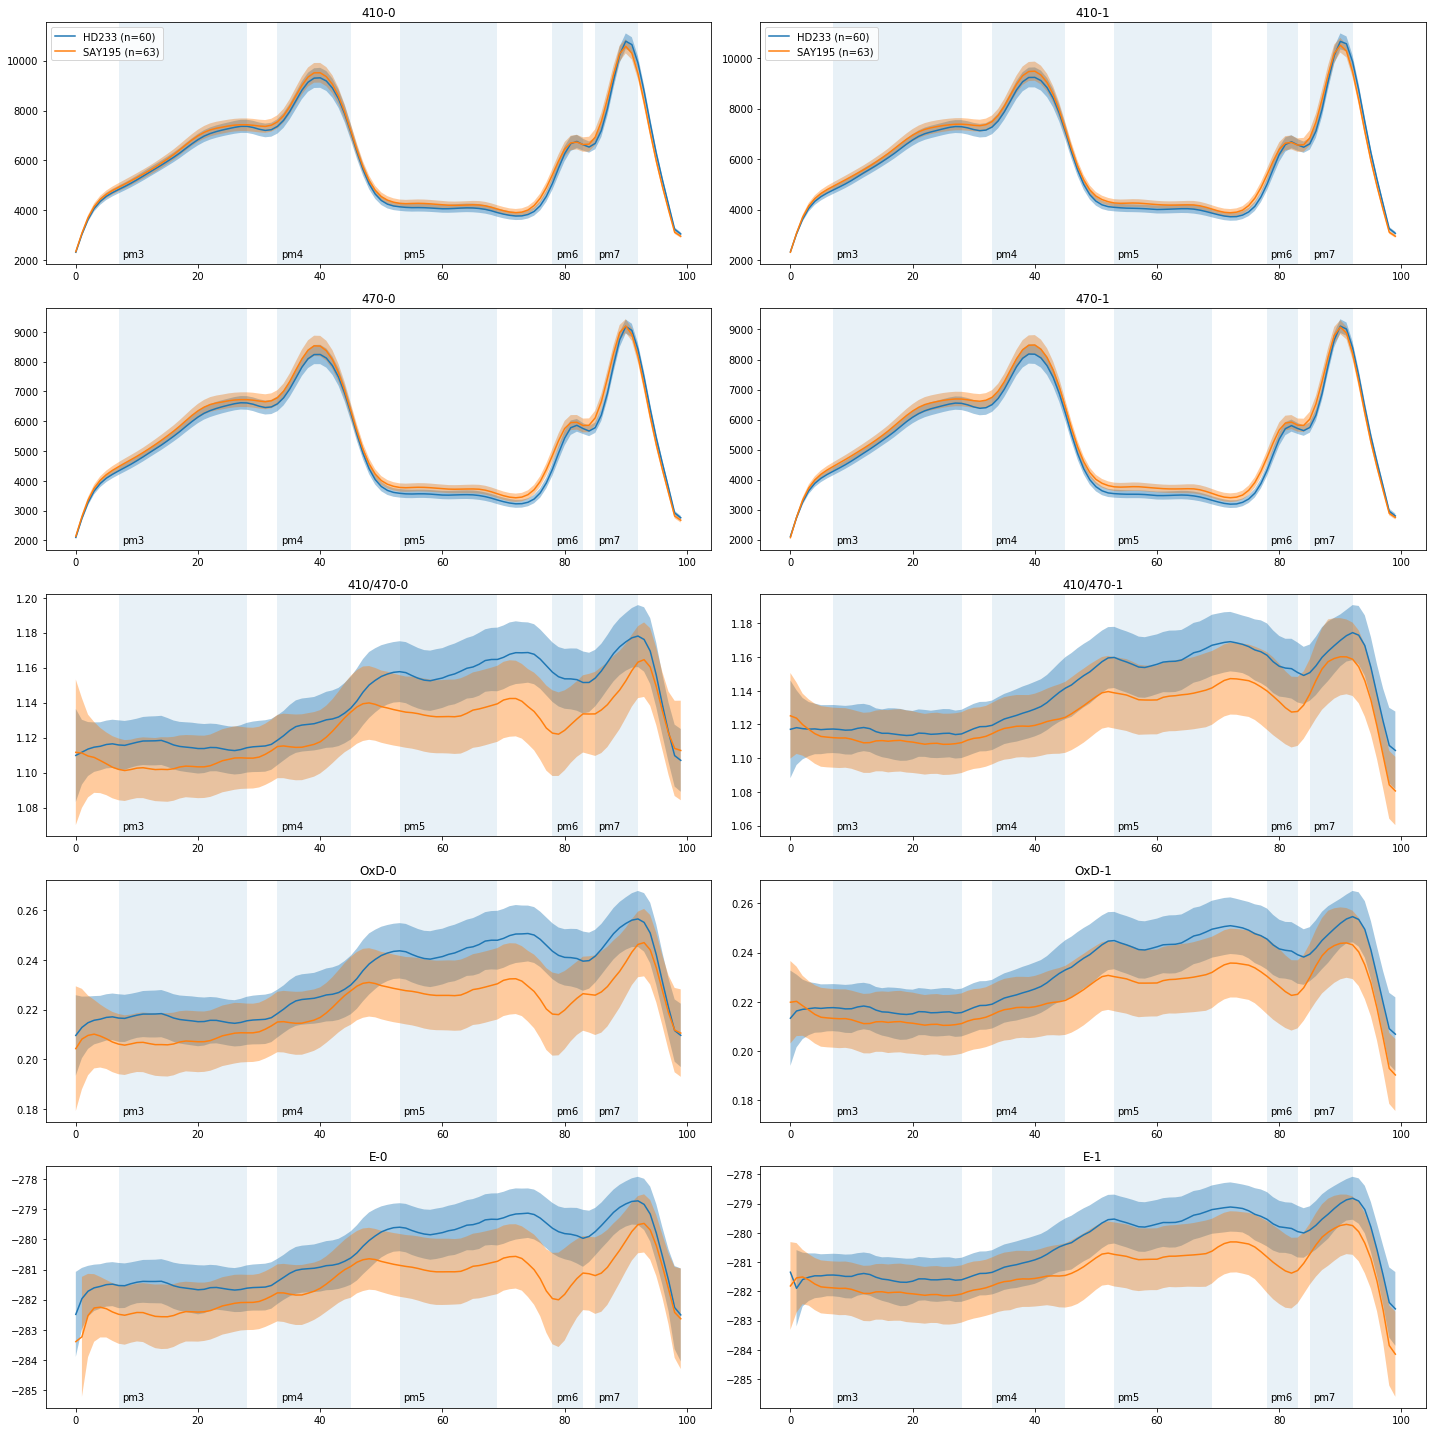

In [29]:
experiment_dir = "/Users/sean/code/wormAnalysis/data/paired_ratio/2019_04_03_ASI_ablation/"
imaging_scheme = "TL/470/410/470/410"

reload(experiment);
ex = experiment.PairExperiment(
    experiment_dir=experiment_dir,
    imaging_scheme=imaging_scheme
)

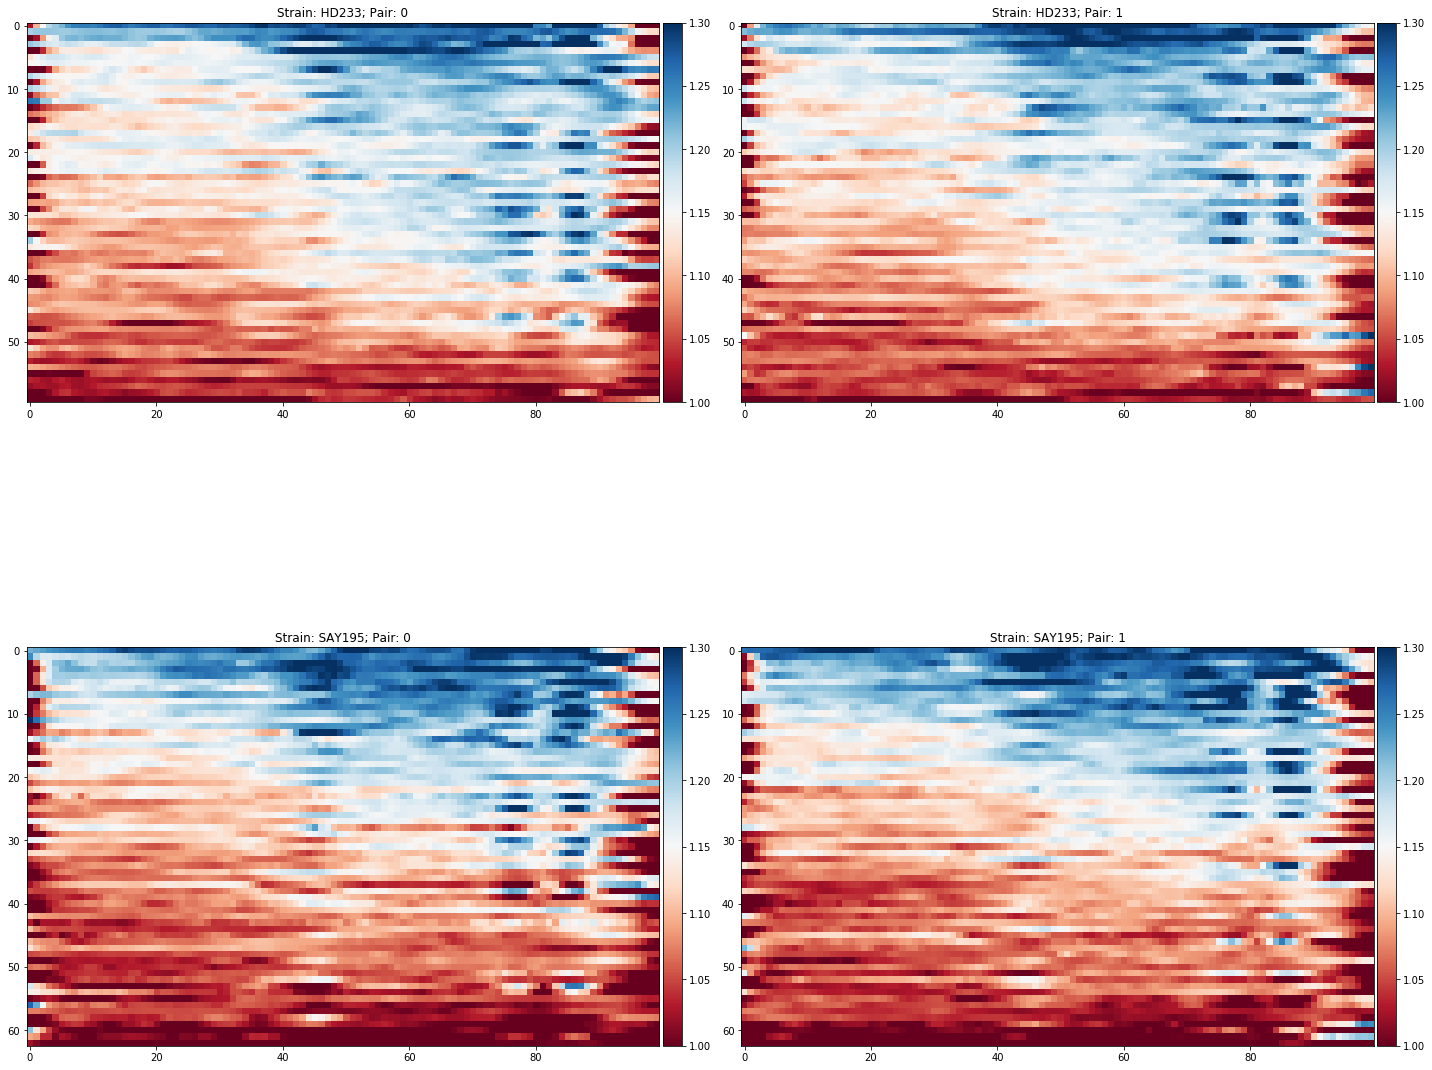

In [62]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

data = ex.trimmed_intensity_data.sel(wavelength='r')

strains = np.unique(data.strain.data)
n_strains = len(strains)
n_pairs = len(data.pair)
fig, axes = plt.subplots(n_strains, n_pairs, figsize=(20,20))
for strain, ax in zip(strains, axes):
    for i in range(n_pairs):
        subset = data.sel(strain=strain).isel(pair=i)
        sorted_idx = np.flip(np.argsort(subset.mean(dim='position'))).data
        
        divider = make_axes_locatable(ax[i])
        cax = divider.append_axes('right', size='3%', pad=0.05)

        ax[i].set_title(f'Strain: {strain}; Pair: {i}')
        im = ax[i].imshow(subset[sorted_idx], cmap='RdBu')
        im.set_clim([1, 1.3])
        fig.colorbar(im, cax=cax, orientation='vertical')

plt.tight_layout()

In [92]:
dp = pd.read_csv('/Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47/2017_02_22-HD233_SAY47_mvmt_sean.csv')
dp = dp[dp.experiment == '2017_02_22-HD233_SAY47']
dp = dp.pivot_table(index='animal', columns=['region', 'pair'], values='movement')
dp = dp.stack('pair')
dp.head()

FileNotFoundError: [Errno 2] File b'/Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47/2017_02_22-HD233_SAY47_mvmt_sean.csv' does not exist: b'/Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47/2017_02_22-HD233_SAY47_mvmt_sean.csv'

In [91]:
data = ex.trimmed_intensity_data
dfs = []
for region, bounds in ex.scaled_regions.items():
    region_dfs = []
    for wvl in data.wavelength.data:
        sub_df = ex.trimmed_intensity_data[dict(position=range(bounds[0],bounds[1]))].mean(dim='position').sel(wavelength=wvl).to_pandas()
        sub_df = sub_df.reset_index()
        sub_df['animal'] = range(len(sub_df))
        sub_df['region'] = region
        sub_df['experiment'] = ex.experiment_id
        sub_df = sub_df.melt(value_vars=[0, 1], var_name='pair', id_vars=['animal', 'strain', 'region', 'experiment'], value_name=wvl)
        region_dfs.append(sub_df)
    df_tmp = pd.concat(region_dfs, axis=1)
    df_tmp = df_tmp.loc[:,~df_tmp.columns.duplicated()]
    dfs.append(df_tmp)
df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)
df = df.join(dp, on=['animal', 'pair'])
df.to_csv('/Users/sean/Desktop/regions.csv', index=False)
df.head()

NameError: name 'dp' is not defined

NameError: name 'hide_current_axis' is not defined

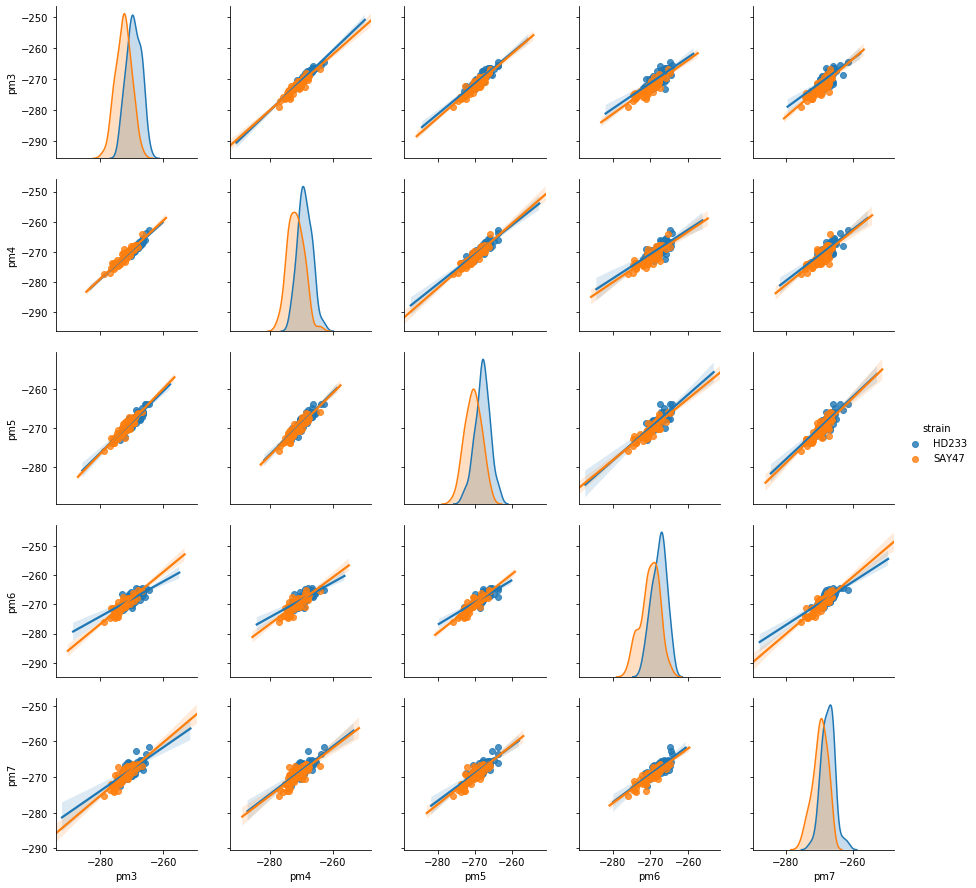

In [819]:
g = sns.pairplot(reshaped, kind='reg', diag_kind='kde', hue='strain', )
# g.map_upper(hide_current_axis)

In [152]:
from matplotlib.gridspec import GridSpec
from matplotlib.backends.backend_pdf import PdfPages


with PdfPages('/Users/sean/Desktop/test.pdf') as pdf:
    for i in range(len(ex.strains)):
        fig = plt.figure(constrained_layout=True, figsize=(15,15))
        gs = GridSpec(5,3, figure=fig)
        midline_xs = np.arange(40,120)

        for pair in range(ex.raw_image_data.pair.size):
            i410 = ex.rot_fl.sel(wavelength='410', pair=pair).isel(strain=i)
            i470 = ex.rot_fl.sel(wavelength='470', pair=pair).isel(strain=i)
            ax = fig.add_subplot(gs[pair,0])
            ax.imshow(i410)
            ax.plot(midline_xs, ex.midlines[i]['410'][pair](midline_xs), color='orange')
            ax.set_title(f'410-{pair}')

            ax = fig.add_subplot(gs[pair,1])
            ax.imshow(i470)
            ax.plot(midline_xs, ex.midlines[i]['470'][pair](midline_xs), color='r')
            ax.set_title(f'470-{pair}')

            ax = fig.add_subplot(gs[pair,2])
            ax.imshow(i410 / i470)
            ax.plot(midline_xs, ex.midlines[i]['410'][pair](midline_xs), color='orange', label='410', alpha=0.5)
            ax.plot(midline_xs, ex.midlines[i]['470'][pair](midline_xs), color='r', label='470', alpha=0.5)
            ax.set_title(f'(410/470)-{pair}')
            ax.legend()

        ax = fig.add_subplot(gs[2,:])
        for pair in range(ex.raw_image_data.pair.size):
            ax.plot(ex.trimmed_intensity_data.sel(wavelength='410', pair=pair).isel(strain=i), label=f'410-{pair}')
            ax.plot(ex.trimmed_intensity_data.sel(wavelength='470', pair=pair).isel(strain=i), label=f'470-{pair}')
        ax.legend()


        ax = fig.add_subplot(gs[3:,:])
        for pair in range(ex.raw_image_data.pair.size):
            ax.plot(ex.trimmed_intensity_data.sel(wavelength='e', pair=pair).isel(strain=i), label=f'E-{pair}')
            ax.set_ylim([np.nanquantile(ex.trimmed_intensity_data.sel(wavelength='e').data, .05),
                         np.nanquantile(ex.trimmed_intensity_data.sel(wavelength='e').data, .95)])
        ax.legend()

        plt.suptitle(f'Animal {i} ({ex.strains[i]})')

        pdf.savefig(fig)
        plt.close()

11:57:42 DEBUG:Assigning font /b'F1' = '/Users/sean/.local/share/virtualenvs/worm/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
12:01:49 DEBUG:Embedding font /Users/sean/.local/share/virtualenvs/worm/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
12:01:49 DEBUG:Writing TrueType font.


In [163]:
def diagnostic_plot(experiment, i):
    fig = plt.figure(constrained_layout=True, figsize=(15,15))
    gs = GridSpec(5,3, figure=fig)
    midline_xs = np.arange(40,120)

    for pair in range(ex.raw_image_data.pair.size):
        i410 = ex.rot_fl.sel(wavelength='410', pair=pair).isel(strain=i)
        i470 = ex.rot_fl.sel(wavelength='470', pair=pair).isel(strain=i)
        ax = fig.add_subplot(gs[pair,0])
        ax.imshow(i410)
        ax.plot(midline_xs, ex.midlines[i]['410'][pair](midline_xs), color='orange')
        ax.set_title(f'410-{pair}')

        ax = fig.add_subplot(gs[pair,1])
        ax.imshow(i470)
        ax.plot(midline_xs, ex.midlines[i]['470'][pair](midline_xs), color='r')
        ax.set_title(f'470-{pair}')

        ax = fig.add_subplot(gs[pair,2])
        ax.imshow(i410 / i470)
        ax.plot(midline_xs, ex.midlines[i]['410'][pair](midline_xs), color='orange', label='410', alpha=0.5)
        ax.plot(midline_xs, ex.midlines[i]['470'][pair](midline_xs), color='r', label='470', alpha=0.5)
        ax.set_title(f'(410/470)-{pair}')
        ax.legend()

    ax = fig.add_subplot(gs[2,:])
    for pair in range(ex.raw_image_data.pair.size):
        ax.plot(ex.trimmed_intensity_data.sel(wavelength='410', pair=pair).isel(strain=i), label=f'410-{pair}')
        ax.plot(ex.trimmed_intensity_data.sel(wavelength='470', pair=pair).isel(strain=i), label=f'470-{pair}')
    ax.legend()


    ax = fig.add_subplot(gs[3:,:])
    for pair in range(ex.raw_image_data.pair.size):
        ax.plot(ex.trimmed_intensity_data.sel(wavelength='e', pair=pair).isel(strain=i), label=f'E-{pair}')
        ax.set_ylim([np.nanquantile(ex.trimmed_intensity_data.sel(wavelength='e').data, .01),
                     np.nanquantile(ex.trimmed_intensity_data.sel(wavelength='e').data, .99)])
    ax.legend()

    plt.suptitle(f'Animal {i} ({ex.strains[i]})')
    
    return fig

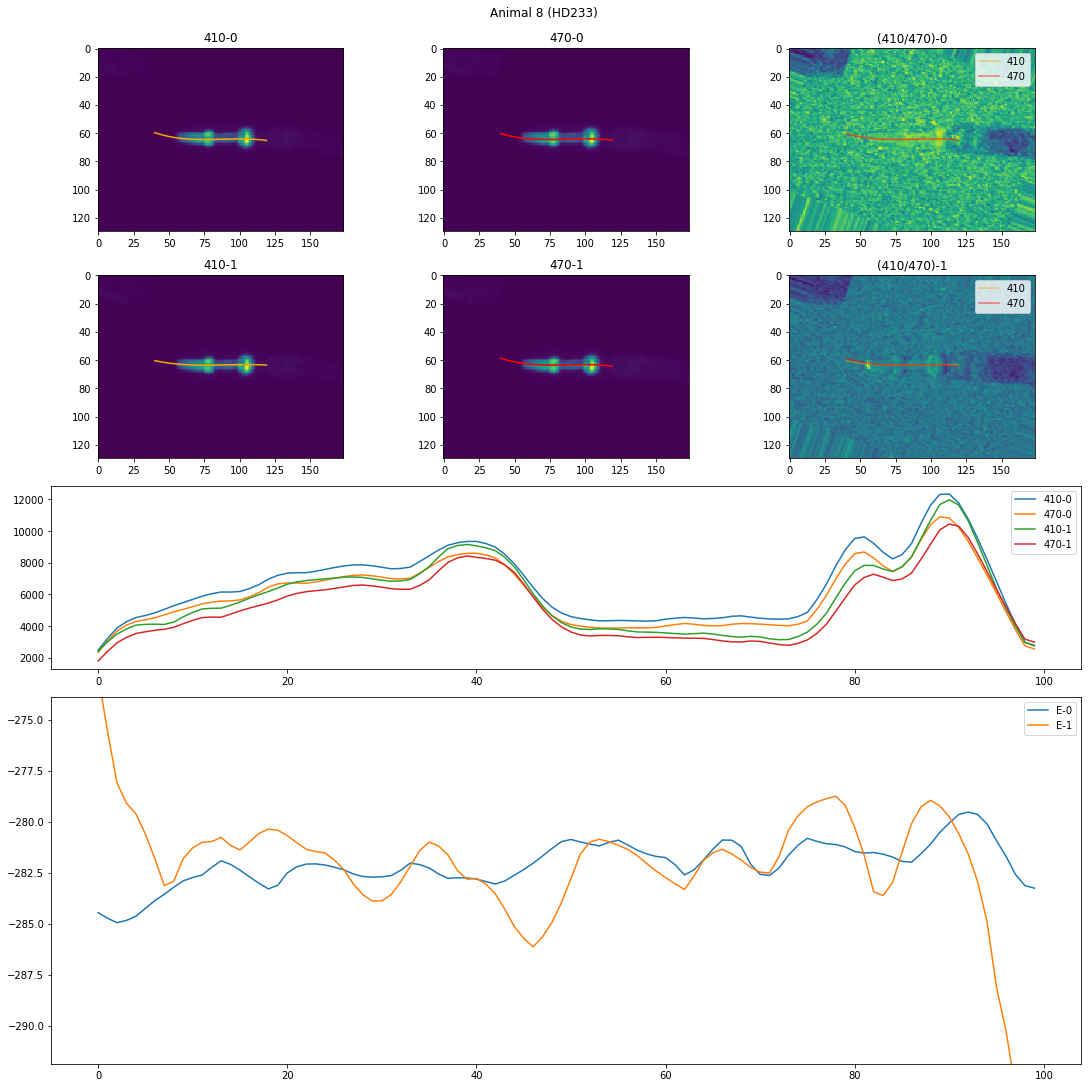

In [167]:
diagnostic_plot(ex, 8)